## Modeling

This notebook begins the modeling process for our data set. I will work through several different machine learning algorithms and choose which one is the best based on several metrics including precision and recall.

In [236]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keplerutils
import seaborn as sns

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC # Support vector machines
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB # Gaussian Naive Bayes
from sklearn.naive_bayes import BernoulliNB # Bernoulli Naive Bayes
from sklearn.naive_bayes import MultinomialNB # Multinomial Naive Bayes
from sklearn import tree # Decision tree
from sklearn.linear_model import SGDClassifier # Stochastic gradient descent 

from imblearn.over_sampling import SMOTE

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [240]:
df['slogg_exp'] = np.exp(df['slogg'])

In [241]:
df.head()

,disposition,period,time0bk,impact,duration,depth,prad,teq,insol,model_snr,steff,slogg,srad,ra,dec,kepmag,slogg_exp
0,1,9.488036,170.538750,0.146,2.95750,615.8,2.26,793.0,93.59,35.8,5455.0,4.467,0.927,291.93423,48.141651,15.347,87.095046
1,1,54.418383,162.513840,0.586,4.50700,874.8,2.83,443.0,9.11,25.8,5455.0,4.467,0.927,291.93423,48.141651,15.347,87.095046
2,0,19.899140,175.850252,0.969,1.78220,10829.0,14.60,638.0,39.30,76.3,5853.0,4.544,0.868,297.00482,48.134129,15.436,94.066314
3,0,1.736952,170.307565,1.276,2.40641,8079.2,33.46,1395.0,891.96,505.6,5805.0,4.564,0.791,285.53461,48.285210,15.597,95.966579
4,1,2.525592,171.595550,0.701,1.65450,603.3,2.75,1406.0,926.16,40.9,6031.0,4.438,1.046,288.75488,48.226200,15.509,84.605561


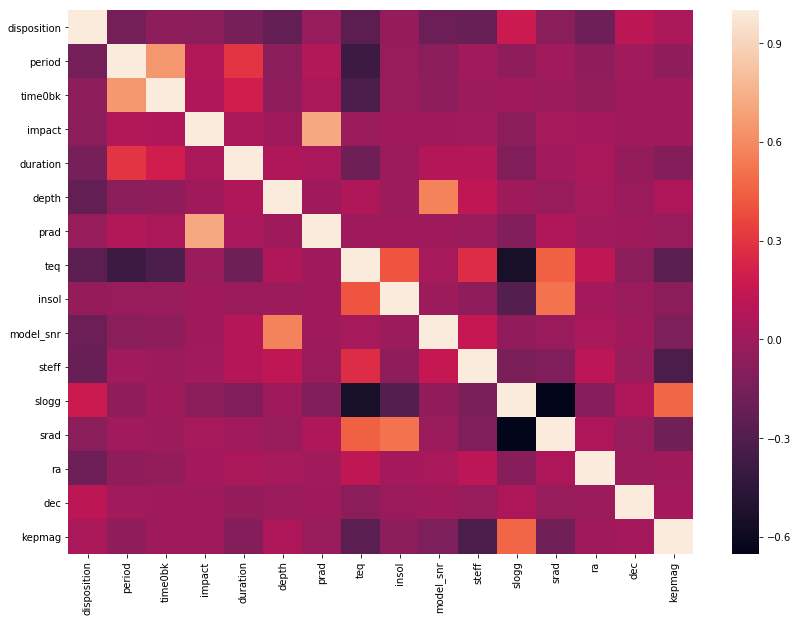

In [238]:
plt.figure(figsize=(14, 10))
sns.heatmap(df.corr())

In [2]:
df = pd.read_csv('objects-of-interest.csv', index_col = 0)

In [3]:
df = df.drop(labels=['rowid', 'kepoi_name', 'pdisposition', 'tce_delivname', 'kepid'], axis=1)

In [4]:
df = df.drop(labels=['tce_plnt_num'], axis=1)

In [196]:
df['disposition'] = df['disposition'].apply(lambda x: keplerutils.encode_response(x))

In [197]:
df.head()

,disposition,period,time0bk,impact,duration,depth,prad,teq,insol,model_snr,steff,slogg,srad,ra,dec,kepmag
0,1,9.488036,170.538750,0.146,2.95750,615.8,2.26,793.0,93.59,35.8,5455.0,4.467,0.927,291.93423,48.141651,15.347
1,1,54.418383,162.513840,0.586,4.50700,874.8,2.83,443.0,9.11,25.8,5455.0,4.467,0.927,291.93423,48.141651,15.347
2,0,19.899140,175.850252,0.969,1.78220,10829.0,14.60,638.0,39.30,76.3,5853.0,4.544,0.868,297.00482,48.134129,15.436
3,0,1.736952,170.307565,1.276,2.40641,8079.2,33.46,1395.0,891.96,505.6,5805.0,4.564,0.791,285.53461,48.285210,15.597
4,1,2.525592,171.595550,0.701,1.65450,603.3,2.75,1406.0,926.16,40.9,6031.0,4.438,1.046,288.75488,48.226200,15.509


In the `disposition` column, 1 means an object of interest was confirmed as an exoplanet, and a 0 means an object of interest was not an exoplanet.

## Models to test:

* KNN
* Logistic regression
* Random forest
* Naive Bayes (Gaussian, Bernoulli)
* Decision tree
* Gradient descent (vanilla, stochastic, mini batch)
* SVM 
* Gradient boosting

First we need to establish a train test split of our data and save it to a dataframe.

In [208]:
X_train_res, X_test, y_train_res, y_test = keplerutils.split_and_upsample(df)

## K Nearest Neighbors

In [209]:
def knnCV(X_train_res, y_train_res):
    '''Splits data in to test and training data, 10-fold cross-validates on training data,
       calculates scoring metric, and returns the mean of that scoring metric
       ----Parameters----
       df: Pandas dataframe with response in 0th column, features in rest of columns
       ----Returns----
       np.mean(scores): the mean of the scores calculated by cross_val_score
    '''     
    pipe = make_pipeline(StandardScaler(), KNeighborsClassifier())
    
    tuning_params = {'kneighborsclassifier__n_neighbors': [i for i in range(2, 20)],
                     'kneighborsclassifier__weights': ['distance', 'uniform']}
    
    g = RandomizedSearchCV(pipe, tuning_params, scoring='roc_auc', cv=5, n_jobs = -1)
    
    g.fit(X_train_res, y_train_res)    
            
    print('Best parameters: ', g.best_params_)
    
    print('Mean AUC grid scores: ', g.cv_results_['mean_test_score'])

In [211]:
knnCV(X_train_res, y_train_res)

Best parameters:  {'kneighborsclassifier__weights': 'distance', 'kneighborsclassifier__n_neighbors': 15}
Mean AUC grid scores:  [0.91417124 0.91765818 0.9187453  0.91882683 0.91546152 0.9333432
 0.9192428  0.9181425  0.92824231 0.93225095]


## Logistic Regression

In [215]:
def logisticCV(X_train_res, y_train_res):
    '''
        Performs logistic regression with 5-fold cross validated grid search on training data.
        Prints AUC scores and best parameters.
       ----Parameters----
        X_train_res: SMOTE-resampled features
        y_train_res: SMOTE-resampled response
        '''
    X_train_res, X_test, y_train_res, y_test = split_and_upsample(df)
    
    pipe = make_pipeline(StandardScaler(), LogisticRegression(solver='liblinear', max_iter=1000))
        
    tuning_params = {'logisticregression__C': [1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4, 1e5, 1e6, 1e7]}
    
    g = GridSearchCV(pipe, tuning_params, scoring='roc_auc', cv=5, n_jobs = -1)
    
    g.fit(X_train_res, y_train_res)
        
    print('Best parameters: ', g.best_params_)
    
    print('Mean ROC grid scores: ', g.cv_results_['mean_test_score'])

In [216]:
logisticCV(X_train_res, y_train_res)

Best parameters:  {'logisticregression__C': 100000.0}
Mean ROC grid scores:  [0.88908328 0.90907156 0.91640863 0.91887168 0.92174481 0.92343825
 0.92360249 0.92362452 0.92361601 0.92359898]


## Random Forest

In [234]:
def RFCCV(X_train_res, y_train_res):
    '''
        Performs Random Forest Classificiation with 5 fold cross validation on training data.
        Prints ROC and and best parameters.
        ----Parameters----
        X_train_res: SMOTE-resampled features
        y_train_res: SMOTE-resampled response
    '''                
    pipe = make_pipeline(StandardScaler(), RandomForestClassifier())
        
    tuning_params = {'randomforestclassifier__max_depth': [50, 100, 150, 200], 
                     'randomforestclassifier__n_estimators': [50, 100, 150, 200]}
    
    g = GridSearchCV(pipe, tuning_params, scoring='roc_auc', cv=5, n_jobs = -1)
    
    g.fit(X_train_res, y_train_res)
        
    print('Best parameters: ', g.best_params_)
    
    print('Mean ROC grid scores: ', g.cv_results_['mean_test_score'])

In [235]:
RFCCV(X_train_res, y_train_res)

Best parameters:  {'randomforestclassifier__max_depth': 200, 'randomforestclassifier__n_estimators': 100}
Mean ROC grid scores:  [0.98479089 0.98534    0.98601122 0.98572817 0.98538858 0.98587844
 0.9856436  0.98580957 0.98515082 0.98544969 0.98576535 0.98600824
 0.98477615 0.98644185 0.98568751 0.98616326]


## Support vector machines

In [ ]:
def SVMCV(df):
    

## Gaussian Naive Bayes

In [224]:
def GNBCV(X_train_res, y_train_res):
    '''
        Performs Gaussian Naive Bayes classification with 5 fold cross validation on training data and
        prints f1 macro score.
        ----Parameters----
        X_train_res: SMOTE-resampled features
        y_train_res: SMOTE-resampled response
    '''
        
    pipe = make_pipeline(StandardScaler(), GaussianNB())
    
    pipe.fit(X_train_res, y_train_res)
    
    scores = cross_val_score(pipe, X_train_res, y_train_res, cv=5, scoring='roc_auc')
    
    print('Cross validation ROC:', np.mean(scores))

In [225]:
GNBCV(X_train_res, y_train_res)

Cross validation ROC: 0.9014331290671367


## Bernoulli Naive Bayes

In [228]:
def BNBCV(X_train_res, y_train_res):
    '''
        Performs Bernoulli Naive Bayes classification with 5 fold cross validation on training data and
        prints f1 macro score.
        ----Parameters----
        X_train_res: SMOTE-resampled features
        y_train_res: SMOTE-resampled response
    '''
        
    pipe = make_pipeline(StandardScaler(), BernoulliNB())
    
    pipe.fit(X_train_res, y_train_res)
    
    scores = cross_val_score(pipe, X_train_res, y_train_res, cv=5, scoring='roc_auc')
    
    print('Cross validation ROC:', np.mean(scores))

In [229]:
BNBCV(X_train_res, y_train_res)

Cross validation ROC: 0.8193913246589553


In [ ]:
def treeCV(X_train_res, y_train_res):
    '''
        Performs Decision Tree Classification with 5 fold cross validation on training data.
        Prints ROC and and best parameters.
        ----Parameters----
        X_train_res: SMOTE-resampled features
        y_train_res: SMOTE-resampled response
    '''
    
    pipe = make_pipeline(StandardScaler(), tree())
    
    pipe.fit(X_train_res, y_train_res)
    
    
    
    